# Tikhonov Regularization Tutorial: Seattle-Tacoma Housing Data

**Intro**

This tutorial shows how to use custom regularization with quantcore.glm. The `P2` parameter of the `GeneralizedLinearRegressor` class allows you to directly set the L2 penalty of `w*P2*w` (Tikhonov regularization). A 2d array is directly used as the square matrix `P2`, and a 1d array is interpreted as diagonal (square) matrix. 

*Note*: L1 regularization with parameter `P1` is also avaiable for the 1D option, which is not shown in this tutorial


**Background**

For this tutorial, we will model the selling price of homes in King's County, Washington (Seattle-Tacoma Metro area) between May 2014 and May 2015. However, there is one caveat -- we are going to focus on modeling the selling price of homes in a specific region, but will only using a very small, skewed data sample from that region in our training data. To do this, we will focus on the geographic features of the dataset and show how we can use Tikhonov regularization to minimize overfitting due to noisy/skewed training data. Specifically, we will show that when we have (a) a fixed effect for each postal code region and (b) only a select number of training observations in a certain region, we can improve the predictive power of our model by regularizing the difference between the coefficients of neighboring regions.

*Note*: a few parts of this tutorial utilize local helper functions outside this notebook. If you wish to run the notebook on your own, you can find the rest of the code here: <span style="color:red">**TODO**: add link once in master</span>.


## Table of Contents <a class="anchor" id="toc"></a>
* [1. Load and Prepare Datasets from Openml.org](#1-load)
* [2. Visualize Geographic Data with GIS Open Data](#2-visualize)
* [3. Feature Selection and Transformation](#3-transform)
* [4. Create P matrix](#4-matrix)
* [5. Fit Models](#5-model)

In [1]:
import geopandas as geopd
import libpysal
import matplotlib.pyplot as plt
import numpy as np
import openml
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from quantcore.glm import GeneralizedLinearRegressor

import sys
sys.path.append("../")
from metrics import root_mean_squared_percentage_error

import helpers 

## 1. Load and Prepare Datasets from Openml Data <a class="anchor" id="1-load"></a>
[back to table of contents](#toc)

### 1.1. Download and Transform
The main dataset is downloaded from openml. You can find the main page for the dataset [here](https://www.openml.org/d/42092). It is also available through kaggle [here](https://www.kaggle.com/harlfoxem/housesalesprediction). 

As part of data preparation, we also do some transformations to the data:
- It is expected that factors influencing housing prices are multiplicative rather than additive, so we take the log of price
- We remove some outliers (homes over 1.5 million and under 100k). 
- Since we want to focus on geographic features, we remove a handful of the other features

In [2]:
df = helpers.download_and_transform()
df.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_basement,yr_built,zipcode,price
0,3,1.00,1180,1.0,0,0,3,0,1955,98178,12.309982
1,3,2.25,2570,2.0,0,0,3,400,1951,98125,13.195614
2,2,1.00,770,1.0,0,0,3,0,1933,98028,12.100712
3,4,3.00,1960,1.0,0,0,5,910,1965,98136,13.311329
4,3,2.00,1680,1.0,0,0,3,0,1987,98074,13.142166


## 2. Visualize Geographic Data with GIS Open Data <a class="anchor" id="2-visualize"></a>
[back to table of contents](#toc)

To help visualize the geographic data, we use geopandas and GIS Open Data to display price information on the King's county map. You can get the map data [here]("https://gis-kingcounty.opendata.arcgis.com/datasets/all-zipcodes-and-po-box-as-centroids-for-king-county-zipcode-all-point/data?geometry=-126.017%2C46.845%2C-116.788%2C48.144&page=2"). 

To show the relatioship between home price and geography, we merge the map data with our sales data and use a heat map to plot mean home sale price for each postal code region.

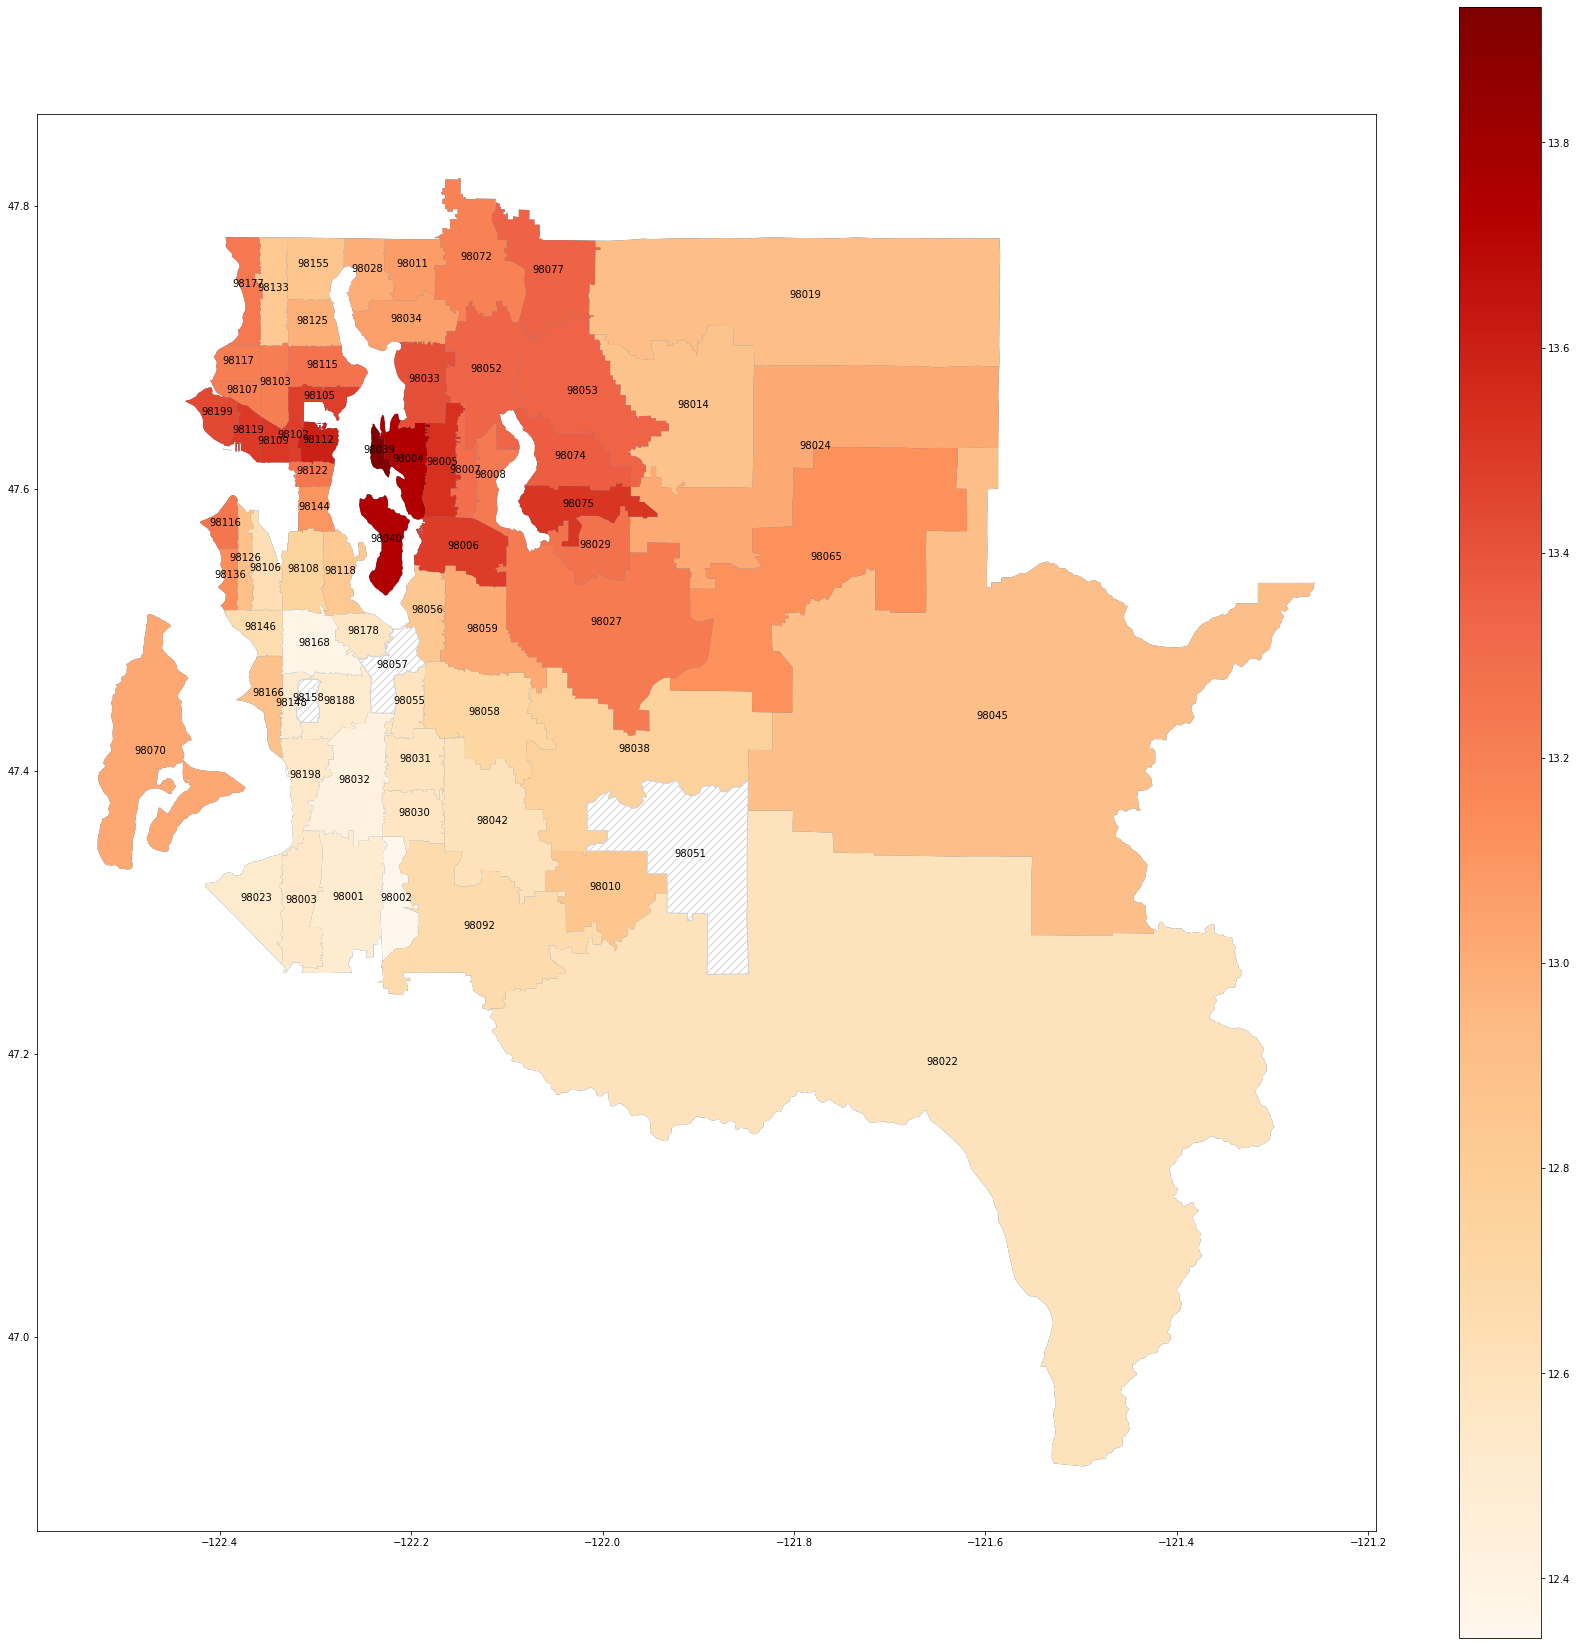

In [3]:
gdf_map = helpers.get_map_data(df)
_ , ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 30))
gdf_map["Region"] = gdf_map["ZIP"]
gdf_map.plot(legend=True, ax=ax)
gdf_map.apply(lambda x: ax.annotate(text=x["ZIP"], xy=x.geometry.centroid.coords[0], ha="center"), axis=1)
gdf_map.plot(
    column="price",
    legend=True,
    ax=ax, cmap="OrRd",
    missing_kwds={"color": "white", "edgecolor": "lightgrey", "hatch": "///",}
)
plt.show()

We can see a clear relationship between postal code and home price. Seattle (98112, 98102, etc.) and the Bellevue/Mercer/Medina suburbs (98039, 98004, 98040) have the highest prices. As you get further from the city, the prices start to drop.

## 3. Feature Selection and Transformation <a class="anchor" id="3-transform"></a>
[back to table of contents](#toc)


### 3.1 Feature selection and one hot encoding
Since we want to focus on geographic data, we drop a number of colums below. We keep a handful of columns so that we can still create a reasonable model. 

We then create a fixed effect for each of the postal code regions. We add the encoded postcode columns in numeric order to help us maintain the proper order of columns while building and training the model. 

In [4]:
sorted_zips = sorted(list(df["zipcode"].unique()))
one_hot = pd.get_dummies(df["zipcode"])
one_hot = one_hot[sorted_zips]
df = df.drop('zipcode', axis=1)
df = one_hot.join(df)
df.head()

,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,...,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_basement,yr_built,price
0,0,0,0,0,0,0,0,0,0,0,...,3,1.00,1180,1.0,0,0,3,0,1955,12.309982
1,0,0,0,0,0,0,0,0,0,0,...,3,2.25,2570,2.0,0,0,3,400,1951,13.195614
2,0,0,0,0,0,0,0,0,0,0,...,2,1.00,770,1.0,0,0,3,0,1933,12.100712
3,0,0,0,0,0,0,0,0,0,0,...,4,3.00,1960,1.0,0,0,5,910,1965,13.311329
4,0,0,0,0,0,0,0,0,0,0,...,3,2.00,1680,1.0,0,0,3,0,1987,13.142166


### 3.2 Test train split
As we mentioned in the introduction, we want to focus on modeling the selling price in a specific region while only using a very small, skewed data sample from that region in our training data. This scenario could arise if say, our task was to predict the sales prices for homes in Enumclaw (large region with zip code 98022 in the southeast corner of the map), but the only data we had from there was from a small luxury realtor.

To mimic this, instead creating a random split between our training and test data, we will intentionally create a highly skewed sample. For our test set, we will take all of the home sales in Enumclaw, *except* for the 15 highest priced homes. 

Finally, we standardize our predictors.

In [5]:
predictors = [c for c in df.columns if c != "price"]

test_region = "98022"
df_train = df[df[test_region] == 0]
df_test = df[df[test_region] == 1].sort_values(by="price", ascending=False)

test_to_train = df_test[:15]

df_train = pd.concat([df_train, test_to_train])
df_test = df_test.drop(test_to_train.index)

X_train = df_train[predictors]
y_train = df_train["price"]
X_test = df_test[predictors]
y_test = df_test["price"]

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## 4. Create P Matrix <a class="anchor" id="4-matrix"></a>
[back to table of contents](#toc)

Now, we will use the geographical information for smoothing. We will create a penalty matrix $P$ such that for neighbouring regions, e.g. for 98022 and 98045, we penalize the squared difference in their coefficient values. For example, if 98022 and 98045 were the only region in question, we would need a $2 \times 2$ matrix $P$ such that:
$$\begin{pmatrix} \beta_{98022}, \beta_{98045}\end{pmatrix} P \begin{pmatrix} \beta_{98022} \\ \beta_{98045}\end{pmatrix}
= (\beta_{98022} - \beta_{98045})^2$$

In this example, we would get this result with $P = \begin{pmatrix} 1 & -1 \\ -1 & 1\end{pmatrix}$. 

Since we have 72 postal code regions, it would be rather annoying to construct this matrix by hand. Luckily, there are libaries that exist for this. We use [pysal](http://pysal.org)'s [pysal.lib.weights.Queen](https://pysal.org/libpysal/generated/libpysal.weights.Queen.html) to retrieve a neighbor's matrix from our map data. The construction of the penalty matrix is rather straightfoward once we have this information.

We leave the non-geographic features unregulated (all zeros in the $P2$ matrix).

In [6]:
# format is {zip1: {neighbord1: 1, neighbor2: 1, ...}}
neighbor_matrix = libpysal.weights.Queen.from_dataframe(gdf_map, ids="ZIP") 

n_features = X_train.shape[1]
P2 = np.zeros((n_features, n_features))

zip2index = dict(zip(sorted_zips, range(len(sorted_zips))))
for zip1 in sorted_zips:
    for zip2 in neighbor_matrix[zip1].keys():
        if zip1 in zip2index and zip2 in zip2index: # ignore regions w/o data 
            if zip2index[zip1] < zip2index[zip2]: # don't repeat if already saw neighbor pair in earlier iteration
                P2[zip2index[zip1], zip2index[zip1]] += 1
                P2[zip2index[zip2], zip2index[zip2]] += 1
                P2[zip2index[zip1], zip2index[zip2]] -= 1
                P2[zip2index[zip2], zip2index[zip1]] -= 1
P2

/Users/mabasta/opt/anaconda3/envs/quantcore.glm/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 98040, 98070.
  warnings.warn(message)


array([[ 3., -1., -1., ...,  0.,  0.,  0.],
       [-1.,  4.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  4., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## 5. Fit Models <a class="anchor" id="5-model"></a>
[back to table of contents](#toc)

Now, we will fit several L2 regularized OLS models using different levels of regularization. All will use the penalty matrix defined above, but the alpha parameter, the constant that multiplies the penalty terms and thus determines the regularization strength, will vary. 

For each model, we will measure test performance using root mean squared percentage error (RMPSE), so that we can get a relaitve result. We will also plot a heatmat of the coefficient values over the regions.

*Note*: alpha=1e-12 is effectively no regularization. The reason we can't set alpha to zero is because we are not dropping any of our zip code categoricals, so actually zero regularization will create a singular matrix error.

alpha=1e-12
Test region coefficient: 0.0007858303279447172
Test RMPSE: 37.94373407584971

alpha=0.1
Test region coefficient: -0.004446581274563474
Test RMPSE: 25.03902629363184

alpha=1
Test region coefficient: -0.012274480602455569
Test RMPSE: 22.915647532195717

alpha=10
Test region coefficient: -0.004606853926374488
Test RMPSE: 23.352359839544807



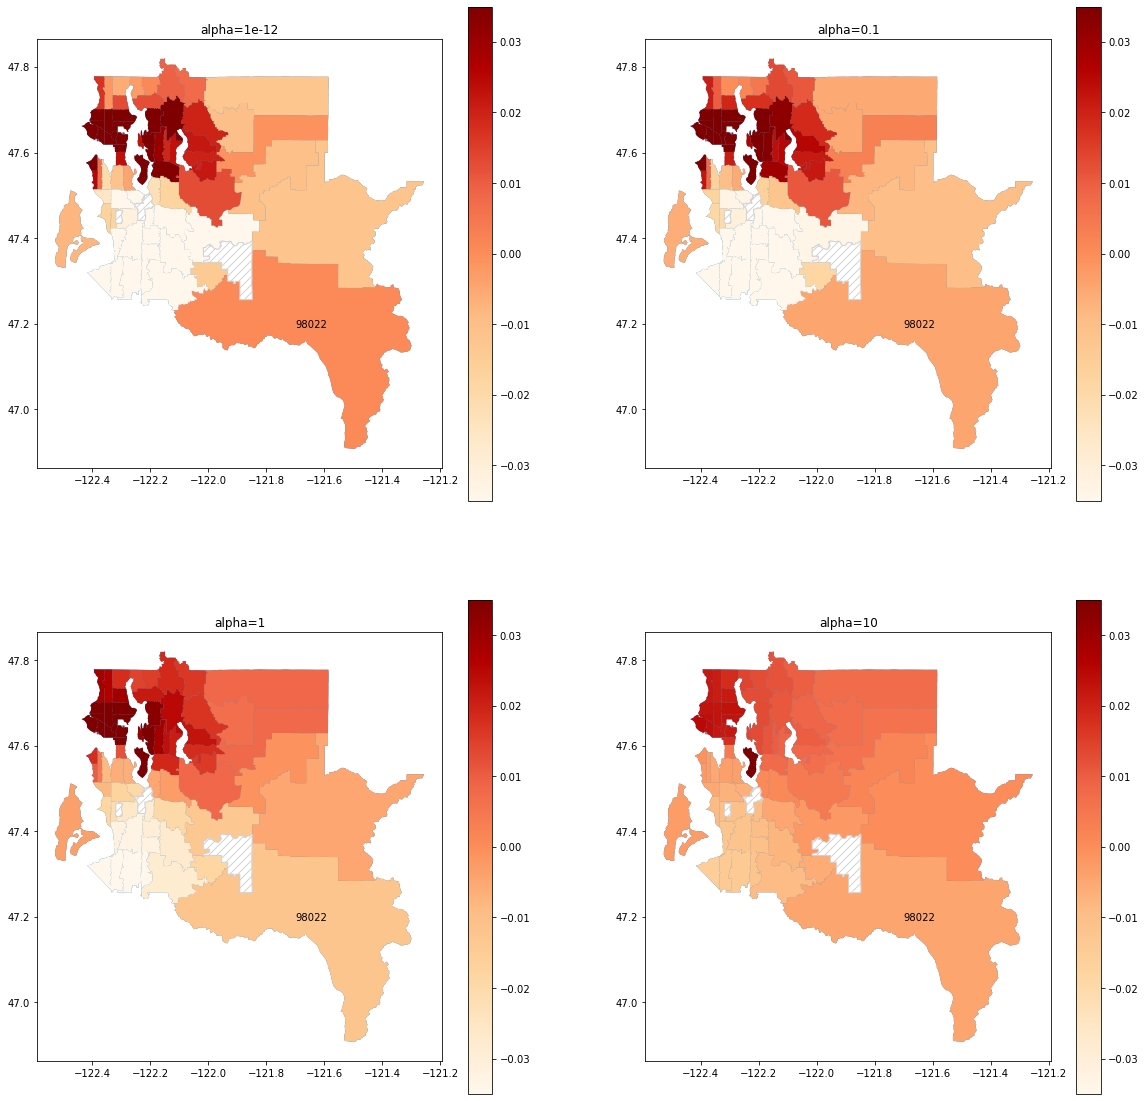

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
for i, alpha in enumerate([1e-12, 1e-1, 1, 10]):
    ax = axs[i//2, i%2]
    glm = GeneralizedLinearRegressor(family='normal', alpha=alpha, P2=P2, fit_intercept=True)
    glm.fit(X_train, y_train)
    y_test_hat = glm.predict(X_test)
    
    coeffs = pd.DataFrame({'coefficient': np.concatenate(([glm.intercept_], glm.coef_))}, ["intercept"]+predictors)
    
    print(f"alpha={alpha}")
    print(f"Test region coefficient: {coeffs.loc[test_region].values[0]}")
    print(f"Test RMPSE: {root_mean_squared_percentage_error(np.exp(y_test_hat), np.exp(y_test))}\n")
    
    gdf_map_coeffs = gdf_map.merge(
        coeffs.loc[sorted_zips],
        left_on="ZIP",
        right_index=True,
        how="outer"
    ).drop_duplicates()
    gdf_map_coeffs["annotation"] = gdf_map_coeffs["ZIP"].apply(lambda x: "" if x!=test_region else x)
    gdf_map_coeffs.plot(legend=True, ax=ax)
    gdf_map_coeffs.apply(
        lambda x: ax.annotate(x["annotation"],
                              xy=x.geometry.centroid.coords[0],
                              ha="center"),
        axis=1)
    gdf_map_coeffs.plot(
        column="coefficient",
        legend=True,
        ax=ax,
        cmap="OrRd",
        vmin=-0.035,
        vmax=0.035,
        missing_kwds={"color": "white", "edgecolor": "lightgrey", "hatch": "///",}
    )
    ax.set_title(f"alpha={alpha}")
          
plt.show()

We can see that our best results are when alpha=1. For lower alpha levels, we can see that the 98022 region coefficient is still much greater than its neighbors (which we can see is not accurate if we refer back to the original map). For higher alpha levels, we start to see things getting overly smooth -- there is very little distinction between the coefficients of each region, and thus regional data loses its predictive power. 

Even though a test percentage error of 18.5% isn't *fantastic* when predicting home prices, it is still much better than the unregulated version (and not bad considering that we only had 10 highly skewed observations from our test region in our training data).